In [57]:
import os, random, math, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

In [58]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Dataset

In [59]:
DATA_ROOT = "/kaggle/input/70-dog-breedsimage-data-set"

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "valid") 
test_dir  = os.path.join(DATA_ROOT, "test")

print("Train exists:", os.path.isdir(train_dir))
print("Valid exists:", os.path.isdir(val_dir))
print("Test exists :", os.path.isdir(test_dir))

Train exists: True
Valid exists: True
Test exists : True


# Classes Count and Images Splitting

In [60]:
def count_images(root):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    counts = []
    for c in classes:
        cpath = os.path.join(root, c)
        n = len([f for f in os.listdir(cpath) if f.lower().endswith((".jpg",".jpeg",".png"))])
        counts.append((c, n))
    df = pd.DataFrame(counts, columns=["class", "count"]).sort_values("count", ascending=False)
    return df, classes

train_df, classes = count_images(train_dir)
val_df, _ = count_images(val_dir)
test_df, _ = count_images(test_dir)

print("Num classes:", len(classes))
print("Train images:", train_df["count"].sum())
print("Val images  :", val_df["count"].sum())
print("Test images :", test_df["count"].sum())

train_df.head()

Num classes: 70
Train images: 7946
Val images  : 700
Test images : 700


,class,count
66,Shih-Tzu,198
49,Lhasa,187
48,Labrador,161
6,Basset,159
63,Scotch Terrier,150


# Ploting The Class Balance

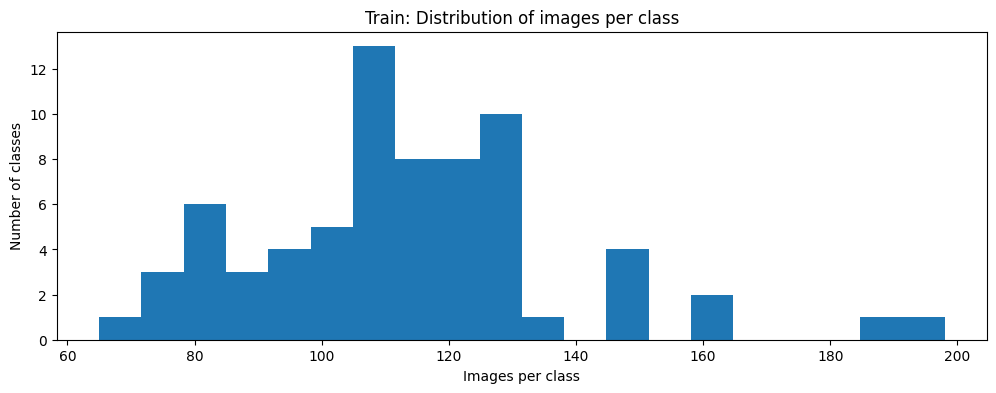

,count
count,70.000000
mean,113.514286
std,24.683353
min,65.000000
25%,99.000000
50%,111.500000
75%,125.000000
max,198.000000


In [61]:
plt.figure(figsize=(12,4))
plt.hist(train_df["count"], bins=20)
plt.title("Train: Distribution of images per class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

train_df.describe()

# Visualize the Random Samples

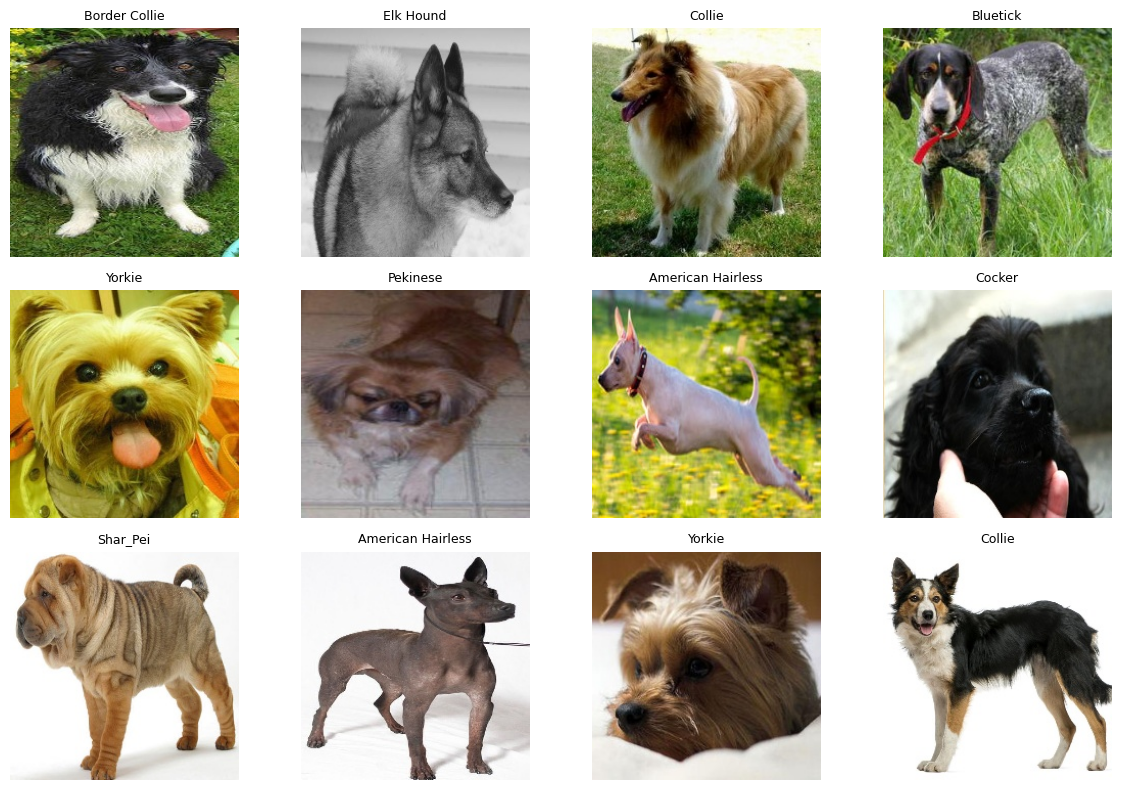

In [62]:
def show_samples(root, classes, n=12):
    plt.figure(figsize=(12,8))
    for i in range(n):
        c = random.choice(classes)
        cdir = os.path.join(root, c)
        img_name = random.choice(os.listdir(cdir))
        img_path = os.path.join(cdir, img_name)
        img = Image.open(img_path).convert("RGB")
        plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(c, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_dir, classes, n=12)

# Checking Image Size Consistency

In [63]:
from collections import Counter

def sample_sizes(root, classes, k=300):
    sizes = []
    for _ in range(k):
        c = random.choice(classes)
        cdir = os.path.join(root, c)
        img_name = random.choice(os.listdir(cdir))
        img_path = os.path.join(cdir, img_name)
        img = Image.open(img_path).convert("RGB")
        sizes.append(img.size)  # (W,H)
    return Counter(sizes).most_common(10)

sample_sizes(train_dir, classes, k=300)

[((224, 224), 300)]

In [64]:
import torchvision.transforms.functional as TF

def compute_mean_std(dataset, num_batches=50, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    mean = 0.
    var  = 0.
    n = 0
    for i, (x, _) in enumerate(loader):
        if i >= num_batches: break
        x = x.to(device)  # [B,3,H,W]
        b = x.size(0)
        x = x.view(b, x.size(1), -1)
        mean += x.mean(dim=2).sum(dim=0)
        var  += x.var(dim=2, unbiased=False).sum(dim=0)
        n += b
    mean /= n
    var  /= n
    std = torch.sqrt(var)
    return mean.detach().cpu().numpy(), std.detach().cpu().numpy()

In [65]:
stats_tf = transforms.Compose([transforms.ToTensor()])
tmp_ds = datasets.ImageFolder(train_dir, transform=stats_tf)
mean, std = compute_mean_std(tmp_ds)
mean, std

(array([0.5255064 , 0.48876953, 0.42011154], dtype=float32),
 array([0.24012756, 0.23869722, 0.24134554], dtype=float32))

In [71]:
!pip -q install -U timm

import timm
from timm.data import create_transform

try:
    from timm.data import resolve_data_config
except Exception as e:
    print("resolve_data_config import failed:", e)
    resolve_data_config = None

In [73]:
IMG_SIZE = 224
BATCH_SIZE = 64

# Build a temporary train dataset to get class_to_idx
dummy_tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
train_ds_tmp = datasets.ImageFolder(train_dir, transform=dummy_tf)
num_classes = len(train_ds_tmp.classes)
print("Classes:", num_classes)

# Choose a strong transformer (very reliable for 80%+)
MODEL_NAME = "swin_tiny_patch4_window7_224"   # Recommended
# MODEL_NAME = "deit_small_patch16_224"       # Alternative

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)
cfg = resolve_data_config({}, model=model)

train_tf = create_transform(**cfg, is_training=True)
eval_tf  = create_transform(**cfg, is_training=False)

# IMPORTANT: enforce SAME labels across splits (handles folder-name inconsistencies like double spaces)
from torchvision.datasets import ImageFolder
import re

def canon(s: str) -> str:
    # collapse multiple spaces, strip ends, lowercase
    return re.sub(r"\s+", " ", s.strip()).lower()

class ImageFolderWithCanonicalMap(ImageFolder):
    def __init__(self, root, train_class_to_idx, transform=None):
        super().__init__(root=root, transform=transform)

        # canonical mapping from TRAIN
        train_c2i = {canon(k): v for k, v in train_class_to_idx.items()}

        fixed_samples = []
        missing = set()

        for path, local_target in self.samples:
            class_name = self.classes[local_target]   # folder name in this split
            key = canon(class_name)

            if key not in train_c2i:
                missing.add(class_name)
                continue

            fixed_samples.append((path, train_c2i[key]))

        if missing:
            print("WARNING: Some classes in this split were not matched to train (after normalization):")
            for m in sorted(missing)[:30]:
                print(" -", repr(m))
            if len(missing) > 30:
                print(" ... and", len(missing) - 30, "more")

        self.samples = fixed_samples
        self.targets = [t for _, t in self.samples]

train_ds = ImageFolder(train_dir, transform=train_tf)
val_ds   = ImageFolderWithCanonicalMap(val_dir,  train_ds.class_to_idx, transform=eval_tf)
test_ds  = ImageFolderWithCanonicalMap(test_dir, train_ds.class_to_idx, transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Example class:", train_ds.classes[0])
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))

Classes: 70
Example class: Afghan
Val samples: 700
Test samples: 700


In [74]:
print("Test folders:", len([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]))
for d in sorted(os.listdir(test_dir))[:10]:
    if os.path.isdir(os.path.join(test_dir, d)):
        print(d, "->", len(os.listdir(os.path.join(test_dir, d))))

Test folders: 70
Afghan -> 10
African Wild Dog -> 10
Airedale -> 10
American Hairless -> 10
American Spaniel -> 10
Basenji -> 10
Basset -> 10
Beagle -> 10
Bearded Collie -> 10
Bermaise -> 10


In [75]:
from torch.amp import GradScaler, autocast

EPOCHS = 12
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

# Warmup + cosine (very effective)
total_steps = EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scaler = GradScaler(enabled=torch.cuda.is_available())
best_val_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
global_step = 0

In [77]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss, total_correct, n = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=0.1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        global_step += 1

        b = x.size(0)
        total_loss += loss.item() * b
        total_correct += (logits.argmax(1) == y).sum().item()
        n += b

    train_loss = total_loss / n
    train_acc  = total_correct / n
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_transformer.pth")

print("Best Val Acc:", best_val_acc)

Epoch 01 | Train Acc: 0.4763 | Val Acc: 0.9014
Epoch 02 | Train Acc: 0.7312 | Val Acc: 0.9457
Epoch 03 | Train Acc: 0.7717 | Val Acc: 0.9286
Epoch 04 | Train Acc: 0.8052 | Val Acc: 0.9443
Epoch 05 | Train Acc: 0.8338 | Val Acc: 0.9586
Epoch 06 | Train Acc: 0.8447 | Val Acc: 0.9700
Epoch 07 | Train Acc: 0.8753 | Val Acc: 0.9614
Epoch 08 | Train Acc: 0.8910 | Val Acc: 0.9771
Epoch 09 | Train Acc: 0.9091 | Val Acc: 0.9757
Epoch 10 | Train Acc: 0.9235 | Val Acc: 0.9757
Epoch 11 | Train Acc: 0.9305 | Val Acc: 0.9743
Epoch 12 | Train Acc: 0.9298 | Val Acc: 0.9743
Best Val Acc: 0.9771428571428571
